# Information Retrieval and Web Analytics

#**Part1**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Load Python packages
Let's first import all the packages that you will need during this assignment.

In [3]:
import nltk
nltk.download('stopwords')
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import collections
from numpy import linalg as la
import string
import json
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#### Load data into memory
The dataset is stored in the json file, and it contains 4,000 tweets related to Hurrican Ian. Each line readed represents a tweet, and for each tweet we have its corresponding information.

In [4]:
docs_path = 'drive/Shareddrives/IR/Project/data/tw_hurricane_data.json'
with open(docs_path) as fp:
    lines = fp.readlines()

In [5]:
print("Total number of tweets: {}".format(len(lines)))

Total number of tweets: 4000


First, we will implement the mandatory preprocessing in the function ```clean_tweet(line)```.

It will take as an input a line, and it will:

- Transform into lower case
- Remove punctiation marks
- Tokenize the text to get a list of terms (*split function*)
- Remove stop words
- Stem terms (example: to stem the term 'researcher', we will use ```stemming.stem(researcher)```)

The extra tasks such as removing emojis 

In [6]:
def clean_tweet(line, emojis):
    """
    Preprocess the article text (title + body) removing stop words, stemming,
    transforming in lowercase and return the tokens of the text.
    
    Argument:
    line -- string (text) to be preprocessed
    
    Returns:
    line - a list of tokens corresponding to the input text after the preprocessing
    """

    line=str(line)  # by default everything assumed as string

    line = line.lower()  # transform into lower case

    line = re.sub(r'\\n', ' ', line)  #remove new lines

    line = line.translate(str.maketrans('', '', string.punctuation))  # remove punctuation marks

    line = re.sub(r'http\S+', '', line)  # remove links

    if emojis: # remove emojis
        ### https://gist.github.com/slowkow/7a7f61f495e3dbb7e3d767f97bd7304b
        remove_emojis = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               u"\u2026" # ...
                               u"\u2019" # '
                               u"\u2066"
                               u"\u2069"
                               u"\u231b"
                               "]+", flags=re.UNICODE)
        line = remove_emojis.sub(r'', str(line))

                     
    line = line.split()  # Tokenize the text to get a list of terms

    stop_words = set(stopwords.words("english")) # remove the stopwords
    line = [x for x in line if x not in stop_words]  

    stemmer = PorterStemmer() #stem terms
    line = [stemmer.stem(word) for word in line]    
        
    return line

In [7]:
def process_json_line(json_line):   #given a json line iterates throuhg its content and creates another json with values formated

  new_dict = {}

  index_stored = 0
  for key, value in json_line.items():

    if (key=="full_text"): new_dict["Tweet"] = clean_tweet(value, True) #process tweet

    elif(key=="created_at"): new_dict["Date"] = clean_tweet(value, False) #process tweet date      

    elif(key=="retweet_count"): new_dict["Retweets"] = value #number of retweet, no need of processing

    elif(key=="favorite_count"): new_dict["Likes"] = value #number of likes, no need of processing
    elif(key=="id"): new_dict["Tweet_id"] = [str(value)] #store tweet id as str

    elif(key=="user"): new_dict["Username"] = clean_tweet(value["screen_name"], True) #process username

    elif(key=="entities"): #process hashtags
      hashtags=[]
      for i in range(len(value["hashtags"])):
        hashtags.append(clean_tweet(value["hashtags"][i]["text"], False))
      new_dict["Hashtags"] = hashtags

  new_dict["Url"] = 'https://twitter.com/'+ new_dict["Username"][0] + '/status/' + str(new_dict["Tweet_id"][0]) #generate url

      
  return new_dict

In [8]:
json_processed=[]

for line in lines:

  data=json.loads(line)
  
  json_line=process_json_line(data) #format json

  json_processed.append(json_line) #store line

#### Mapping ids
Mapping tweets IDs with the document IDS.

In [9]:
import csv
mapping_dict = {} # create empty dictionary to store the documents id

docs_path = 'drive/Shareddrives/IR/Project/data/tweet_document_ids_map.csv'
csv_file = csv.reader(open(docs_path, 'rU'), delimiter="\t", quotechar='|') # open csv

for line in csv_file: mapping_dict[line[1]] = line[0]   # store the indexes in the dictionary (tweet id, document id)

for j in json_processed:
  m = []
  m.append(str(mapping_dict[j['Tweet_id'][0]]))
  j['doc_id'] = m   # add the document id in the json dictionary

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: 'U' mode is deprecated
  """


In [10]:
json_processed[39]

{'Date': ['fri', 'sep', '30', '183626', '0000', '2022'],
 'Tweet_id': ['1575917502554513408'],
 'Tweet': ['florida', 'love', 'publix', 'hurricaneian'],
 'Hashtags': [['florida'], ['hurricaneian']],
 'Username': ['momagainstmedia'],
 'Retweets': 0,
 'Likes': 0,
 'Url': 'https://twitter.com/momagainstmedia/status/1575917502554513408',
 'doc_id': ['doc_40']}

In [11]:
print(json_processed[252])

{'Date': ['fri', 'sep', '30', '182614', '0000', '2022'], 'Tweet_id': ['1575914937880305664'], 'Tweet': ['new', 'lawmak', 'governor', 'around', 'countri', 'busi', 'week', 'particularli', 'deal', 'prepar', 'deal', 'hurricaneian', 'east', 'coast', 'latest', 'state', 'state'], 'Hashtags': [['new'], ['hurricaneian']], 'Username': ['dmgsllc'], 'Retweets': 1, 'Likes': 1, 'Url': 'https://twitter.com/dmgsllc/status/1575914937880305664', 'doc_id': ['doc_253']}


#**Part 2**

###Indexing

####  Build inverted index

In [12]:
inverted_index = defaultdict(list)

for j in json_processed:
  terms = j['Tweet']

  current_page_index = {}

  for position, term in enumerate(terms): #Loop over all terms
      try:
          # if the term is already in the index for the current page (current_page_index)
          # append the position to the corresponding list (elemento 1 del arreglo, el 0 es la id del documento)
          current_page_index[term][1].append(position)
      except:
          # Add the new term as dict key and initialize the array of positions and add the position
          current_page_index[term] = [j['doc_id'], array('I', [position])]  #'I' indicates unsigned int (int in Python)

  # merge the current page index with the main index
  for term_page, posting_page in current_page_index.items():
      inverted_index[term_page].append(posting_page)

In [13]:
inverted_index = {key: value for key, value in sorted(inverted_index.items())}

In [14]:
import math
tf_idf = {}

for i in mapping_dict.values():
  tf_idf[i] = [0.0] * len(inverted_index)  # initialize document vectors

for index, term in enumerate(inverted_index):
  df = len(inverted_index[term])  # document frequency of the term 
  for doc in inverted_index[term]:
    f = len(doc[1])  # term frequency of the term in the document doc

    #in this case we only compute weights for terms that appear, so the condition of below is not necessary
    #if f==0:
      #tf_idf[doc[0][0]][index] = 0

    w = (1 + math.log(f, 2)) * math.log(len(mapping_dict) / df, 2)
    tf_idf[doc[0][0]][index] = w

In [15]:
queries = {}
queries["q1"] = clean_tweet("Last hurricane in Florida", True)
queries["q2"] = clean_tweet("Terrible hurricane north carolina", True)
queries["q3"] = clean_tweet("Medical assistance Florida", True)
queries["q4"] = clean_tweet("Last news report Ian", True)
queries["q5"] = clean_tweet("Dealing with east coast tragedy", True)

In [16]:
import math
tf_idf_q = {}

for q in queries.keys():
  tf_idf_q[q] = [0.0] * len(inverted_index)  # initialize document vectors

for index, term in enumerate(inverted_index):
  df = len(inverted_index[term])  # document frequency of the term 
  for k, q in queries.items():
    f =q.count(term)  # term frequency of the term in the query q
    if(f==0):#if frequency is 0, weight is 0
      tf_idf_q[k][index] = 0
    else:
      w = (1 + math.log(f, 2)) * math.log(len(mapping_dict) / df, 2)
      tf_idf_q[k][index] = w


In [17]:
from numpy.linalg import norm
cosine = {"q1":{},"q2":{},"q3":{},"q4":{},"q5":{}}

for q in tf_idf_q.keys():
  query = tf_idf_q[q]
  for d in tf_idf.keys():
    doc = tf_idf[d]
    cosine[q][d] = np.dot(query, doc) / (norm(query) * norm(doc))  # compute cosine similarity

In [18]:
for q in queries:
  cosine[q] = dict(sorted(cosine[q].items(), key=lambda x: x[1], reverse=True))  # sort cosine similarity in descending order

In [19]:
cosine.items()
k_ranking=[0]*5

i=0
for q in queries:
  k_ranking[i] = {k for k in list(cosine[q].keys())[:10]}  # get the top 10 documents for query q using cosine similarity
  print("Ranking for query",i+1,":", k_ranking[i])
  i=i+1


Ranking for query 1 : {'doc_2862', 'doc_1305', 'doc_1655', 'doc_640', 'doc_1154', 'doc_341', 'doc_3884', 'doc_1012', 'doc_2507', 'doc_3287'}
Ranking for query 2 : {'doc_1110', 'doc_2607', 'doc_241', 'doc_3894', 'doc_2151', 'doc_3962', 'doc_1889', 'doc_3418', 'doc_2430', 'doc_2657'}
Ranking for query 3 : {'doc_1412', 'doc_3255', 'doc_1192', 'doc_3766', 'doc_1466', 'doc_828', 'doc_1732', 'doc_1331', 'doc_670', 'doc_1273'}
Ranking for query 4 : {'doc_1923', 'doc_2368', 'doc_2901', 'doc_3057', 'doc_1104', 'doc_2283', 'doc_3150', 'doc_3209', 'doc_2507', 'doc_2083'}
Ranking for query 5 : {'doc_253', 'doc_2565', 'doc_336', 'doc_3285', 'doc_3961', 'doc_1151', 'doc_3466', 'doc_219', 'doc_2182', 'doc_2519'}


###Evaluation

a. Query 1: Landfall in South Carolina

b. Query 2:Help and recovery during the hurricane disaster

c. Query 3:Floodings in South Carolina

In [20]:
import pandas as pd
df_=pd.read_csv('drive/Shareddrives/IR/Project/data/evaluation_gt.csv')

queries = {}
queries_info = [{},{},{}]

queries["q1"]=clean_tweet("Landfall in South Carolina", True) #q1
queries["q2"]=clean_tweet("Help and recovery during the hurricane disaster", True)
queries["q3"]=clean_tweet("Floodings in South Carolina", True)


#compute vector representation of the queries (as in the previous section)
tf_idf_q = {}
for q in queries.keys():
  tf_idf_q[q] = [0.0] * len(inverted_index)  # initialize document vectors

for index, term in enumerate(inverted_index):
  df = len(inverted_index[term])  # document frequency of the term 
  for k, q in queries.items():
    f =q.count(term)  # term frequency of the term in the query q
    if(f==0):#if frequency is 0, weight is 0
      tf_idf_q[k][index] = 0
    else:
      w = (1 + math.log(f, 2)) * math.log(len(mapping_dict) / df, 2)
      tf_idf_q[k][index] = w

cosine = {"q1":{},"q2":{},"q3":{}}

for i in range(len(queries)):
  queries_info[i]=df_.loc[df_["query_id"]==(i+1)] #info about q1
  queries_info[i]=queries_info[i].reset_index()
  docs_set=(queries_info[i]["doc"].tolist()) #documents that we have information about, the ones we will evaluate
  tf_idf_set={k: tf_idf[k] for k in docs_set} #tf_idf of the documents we can evaluate for that query

  query = tf_idf_q["q"+str(i+1)]
  #cosine similarity for q1 docs
  for d in tf_idf_set.keys():
      doc = tf_idf_set[d]
      cosine["q"+str(i+1)][d] = np.dot(query, doc) / (norm(query) * norm(doc))

In [21]:
#rank and output top k documents
for q in queries:
  cosine[q] = dict(sorted(cosine[q].items(), key=lambda x: x[1], reverse=True))  # sort cosine similarity in descending order

k_ranking=[0]*3
i=0
for q in queries:
  k_ranking[i] = {k for k in list(cosine[q].keys())[:10]}  # get the top 10 documents for query q using cosine similarity
  print("Ranking for query",i+1,":", k_ranking[i])
  i=i+1

Ranking for query 1 : {'doc_165', 'doc_82', 'doc_52', 'doc_45', 'doc_12', 'doc_9', 'doc_18', 'doc_501', 'doc_100', 'doc_122'}
Ranking for query 2 : {'doc_373', 'doc_303', 'doc_504', 'doc_1233', 'doc_158', 'doc_268', 'doc_453', 'doc_175', 'doc_321', 'doc_402'}
Ranking for query 3 : {'doc_1195', 'doc_65', 'doc_125', 'doc_198', 'doc_30', 'doc_150', 'doc_148', 'doc_112', 'doc_370', 'doc_66'}


In [22]:
#completing datasets with predicted values
for q in range(len(queries)):
  queries_info[q]["Predicted"]=0

  for i in range(len(queries_info[q])):
    if(queries_info[q].loc[i, "doc"] in k_ranking[q]):
        queries_info[q].loc[i, "Predicted"]=1

  df_mapping = pd.DataFrame({
      'ranking': list(k_ranking[q])
      })

  sort_mapping = df_mapping.reset_index().set_index('ranking')
  queries_info[q]['ranking'] = queries_info[q]['doc'].map(sort_mapping['index'])
  queries_info[q] = queries_info[q].sort_values('ranking')

###### Precision @ K (P@K)


In [23]:
def precision_at_k(doc_score, y_score, k=10): #binary relevance, predicted relevance, k for a given query
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    precision @k : float

    """
    order = np.argsort(y_score)[::-1] #we get the ranking of the documents according to the predicted score/ use np.argsort and [::1] to obtain the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k]) # align the binary relevance to the corresponding document / use the indexes of point 1 to sort the actual relevance label of the documents (hint: np.take).
    relevant = sum(doc_score == 1) #get number of relevant documents
    return float(relevant) / k #calculate precision at k, which is the number of relevant documents trieved at k

In [24]:
k = 10

P1 = precision_at_k(queries_info[0]["label"], queries_info[0]["Predicted"], k)
print("==> Precision@{} of Q1: {}\n".format(k, P1))

P2 = precision_at_k(queries_info[1]["label"], queries_info[1]["Predicted"], k)
print("==> Precision@{} of Q2: {}\n".format(k, P2))

P3 = precision_at_k(queries_info[2]["label"], queries_info[2]["Predicted"], k)
print("==> Precision@{} of Q3: {}\n".format(k, P3))

==> Precision@10 of Q1: 1.0

==> Precision@10 of Q2: 0.9

==> Precision@10 of Q3: 0.8



###### Recall @ K (R@K)

In [25]:
def recall_at_k(doc_score, y_score, k): #binary relevance, predicted relevance, k for a given query
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    precision @k : float

    """
    total_relevant = doc_score
    order = np.argsort(y_score)[::-1] #we get the ranking of the documents according to the predicted score/ use np.argsort and [::1] to obtain the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k]) # align the binary relevance to the corresponding document / use the indexes of point 1 to sort the actual relevance label of the documents (hint: np.take).
    relevant = sum(doc_score == 1) #get number of relevant documents
    return float(relevant) / len(total_relevant) #calculate precision at k, which is the number of relevant documents trieved at k

In [26]:
k = 10

R1 = recall_at_k(queries_info[0]["label"], queries_info[0]["Predicted"], k)
print("==> Recall@{} of Q1: {}\n".format(k, R1))

R2 = recall_at_k(queries_info[1]["label"], queries_info[1]["Predicted"], k)
print("==> Recall@{} of Q2: {}\n".format(k, R2))

R3 = recall_at_k(queries_info[2]["label"], queries_info[2]["Predicted"], k)
print("==> Recall@{} of Q3: {}\n".format(k, R3))

==> Recall@10 of Q1: 0.5

==> Recall@10 of Q2: 0.45

==> Recall@10 of Q3: 0.4



###### Average Precision@K - AP@K

In [27]:
def avg_precision_at_k(doc_score, y_score, k=10): #binary relevance, predicted relevance, k for a given query
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    average precision @k : float
    """
    gtp = np.sum(doc_score == 1) #Total number of gt positives
    order = np.argsort(y_score)[::-1] #same as for precision
    doc_score = np.take(doc_score, order[:k]) #same as for precision
    ## if all documents are not relevant
    if gtp == 0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    for i in range(len(doc_score)):
        if doc_score[i] == 1: #only add the P@k when the doc is relevant
            n_relevant_at_i += 1
            prec_at_i += n_relevant_at_i / (i + 1) #calculate P@K (#docs relevant at k/k)
    return prec_at_i / gtp #return ap

In [28]:
q2_ap=avg_precision_at_k(queries_info[1]["Predicted"], queries_info[1]["label"], k)
print(q2_ap)

0.8521031746031745


In [29]:
k = 10

q1_ap=avg_precision_at_k(queries_info[0]["Predicted"], queries_info[0]["label"], k)
print("==> Average Precision@{} of Q1: {}\n".format(k, q1_ap))

q2_ap=avg_precision_at_k(queries_info[1]["Predicted"], queries_info[1]["label"], k)
print("==> Average Precision@{} of Q2: {}\n".format(k, q2_ap))

q3_ap=avg_precision_at_k(queries_info[2]["Predicted"], queries_info[2]["label"], k)
print("==> Average Precision@{} of Q3: {}\n".format(k, q3_ap))

==> Average Precision@10 of Q1: 1.0

==> Average Precision@10 of Q2: 0.8521031746031745

==> Average Precision@10 of Q3: 0.8333333333333334



###### F1-Score

In [30]:
print(P1, R1)
print(P2, R2)
print(P3, R3)

1.0 0.5
0.9 0.45
0.8 0.4


In [31]:
print("==> F1-score@{} of Q1: {}\n".format(k, 2 * (P1*R1) / (P1 + R1) ))

print("==> F1-score@{} of Q2: {}\n".format(k, 2 * (P2*R2) / (P2 + R2) ))

print("==> F1-score@{} of Q3: {}\n".format(k, 2 * (P3*R3) / (P3 + R3) ))

==> F1-score@10 of Q1: 0.6666666666666666

==> F1-score@10 of Q2: 0.6

==> F1-score@10 of Q3: 0.5333333333333333



###### Mean Average Precision (MAP)

In [32]:
def map_at_k(search_res, k=10): #receives all the search esults dataframe containing all the queries and the results and relevances
    """
    Parameters
    ----------
    search_res: search results dataset containing:
        query_id: query id.
        doc_id: document id.
        predicted_relevance: relevance predicted through LightGBM.
        doc_score: actual score of the document for the query (ground truth).

    Returns
    -------
    mean average precision @ k : float
    """
    avp = []
    for q in search_res:  # loop over all query ids
        curr_data = q  # select data for current query (get a slice of the dataframe keeping only the data related to the current query)
        avp.append(avg_precision_at_k(np.array(curr_data["label"]), 
                   np.array(curr_data["Predicted"]), k))  #append average precision for current query
    return np.sum(avp) / len(avp), avp  # return mean average precision

In [33]:
k = 10
map_k, avp = map_at_k(queries_info, 10)
map_k

0.8602910052910054

In [34]:
# print((q1_ap+q2_ap+q3_ap)/3)

###### Mean Reciprocal Rank (MRR)

In [35]:
def rr_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    Reciprocal Rank for qurrent query
    """

    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order. As before
    doc_score = np.take(doc_score, order[
                             :k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k. As before
    if np.sum(doc_score) == 0:  # if there are not relevant doument return 0
        return 0
    return 1 / (np.argmax(doc_score == 1) + 1)  # hint: to get the position of the first relevant document use "np.argmax" (+1 because the idex starts from 0)


In [36]:
k = 10

for i in range(len(queries)):
  print("==> MRR of Q{}: {}\n".format(i, rr_at_k(queries_info[i]["Predicted"], queries_info[i]["label"], k)))


==> MRR of Q0: 1.0

==> MRR of Q1: 1.0

==> MRR of Q2: 1.0



###### Normalized Discounted Cumulative Gain (NDCG)


  
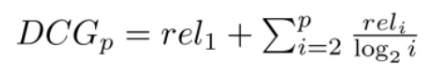

In [37]:

def NDCG(query_ranking):
  NDCG = [0.0] * len(query_ranking)
  DCG = [0.0] * len(query_ranking)
  ideal_DCG = [0.0] * len(query_ranking)
  ideal = query_ranking.sort_values(by=['label'], ascending=False) # Sort to obtain the ideal order
  ideal = ideal.reset_index(drop=True) 
  query_ranking = query_ranking.reset_index(drop=True)

  for d in range(len(query_ranking)):
    
    if d == 0: # First 
      DCG[d] = query_ranking['label'][d]
      ideal_DCG[d] = ideal['label'][d]
    else:
      DCG[d] = DCG[d-1] + query_ranking['label'][d] / math.log( d + 1 ,2)
      ideal_DCG[d] = ideal_DCG[d-1] + ideal['label'][d] / math.log( d + 1 ,2)

    NDCG[d] = DCG[d] / ideal_DCG[d]
    

  return NDCG


In [38]:
for i in range(len(queries)):
  print("NDCG of Q{}:".format(i+1), NDCG(queries_info[i]))


NDCG of Q1: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
NDCG of Q2: [1.0, 1.0, 1.0, 0.8403030283801005, 0.8596139055669277, 0.8733683229467235, 0.883846978032991, 0.8921949032162437, 0.899060546739717, 0.9048433681146754, 0.9598562386525284, 0.9598562386525284, 0.9598562386525284, 0.9598562386525284, 0.9598562386525284, 0.9598562386525284, 0.9598562386525284, 0.9598562386525284, 0.9598562386525284, 0.9598562386525284]
NDCG of Q3: [0.0, 0.5, 0.6199062332840657, 0.5209090851403014, 0.5788417167007833, 0.6201049688401704, 0.6515409340989727, 0.6765847096487312, 0.6971816402191511, 0.7145301043440262, 0.7695429748818793, 0.8226295172745447, 0.8226295172745447, 0.8226295172745447, 0.8226295172745447, 0.8226295172745447, 0.8226295172745447, 0.8226295172745447, 0.8226295172745447, 0.8226295172745447]


### Two-dimensional scatter representation

In [39]:
import gensim
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


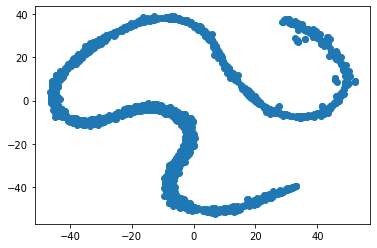

In [40]:
tweets = []
for j in json_processed: tweets.append(j['Tweet'])

model = gensim.models.Word2Vec(tweets)

X_word2vec = model.wv[model.wv.vocab]

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_word2vec)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1])
plt.show()

#**Part 3**

##TF-IDF+ Cosine similarity

In [61]:
import math
tf_idf = {}

for i in mapping_dict.values():
  tf_idf[i] = [0.0] * len(inverted_index)  # initialize document vectors

for index, term in enumerate(inverted_index):
  df = len(inverted_index[term])  # document frequency of the term 
  for doc in inverted_index[term]:
    f = len(doc[1])  # term frequency of the term in the document doc

    #in this case we only compute weights for terms that appear, so the condition of below is not necessary
    #if f==0:
      #tf_idf[doc[0][0]][index] = 0

    w = (1 + math.log(f, 2)) * math.log(len(mapping_dict) / df, 2)
    tf_idf[doc[0][0]][index] = w

queries = {}
queries["q1"] = clean_tweet("Last hurricane in Florida", True)
queries["q2"] = clean_tweet("Terrible hurricane north carolina", True)
queries["q3"] = clean_tweet("Medical assistance Florida", True)
queries["q4"] = clean_tweet("Last news report Ian", True)
queries["q5"] = clean_tweet("Dealing with east coast tragedy", True)

tf_idf_q = {}

for q in queries.keys():
  tf_idf_q[q] = [0.0] * len(inverted_index)  # initialize document vectors

for index, term in enumerate(inverted_index):
  df = len(inverted_index[term])  # document frequency of the term 
  for k, q in queries.items():
    f =q.count(term)  # term frequency of the term in the query q
    if(f==0):#if frequency is 0, weight is 0
      tf_idf_q[k][index] = 0
    else:
      w = (1 + math.log(f, 2)) * math.log(len(mapping_dict) / df, 2)
      tf_idf_q[k][index] = w

from numpy.linalg import norm
cosine = {"q1":{},"q2":{},"q3":{},"q4":{},"q5":{}}

for q in tf_idf_q.keys():
  query = tf_idf_q[q]
  for d in tf_idf.keys():
    doc = tf_idf[d]
    cosine[q][d] = np.dot(query, doc) / (norm(query) * norm(doc))  # compute cosine similarity

for q in queries:
  cosine[q] = dict(sorted(cosine[q].items(), key=lambda x: x[1], reverse=True))  # sort cosine similarity in descending order

cosine.items()
k_ranking=[0]*5

i=0
for q in queries:
  k_ranking[i] = {k for k in list(cosine[q].keys())[:5]}  # get the top 10 documents for query q using cosine similarity
  print("Ranking for query",i+1,":", k_ranking[i])
  i=i+1  

Ranking for query 1 : {'doc_1655', 'doc_341', 'doc_1012', 'doc_2507', 'doc_3287'}
Ranking for query 2 : {'doc_1110', 'doc_241', 'doc_2151', 'doc_1889', 'doc_2430'}
Ranking for query 3 : {'doc_3255', 'doc_1192', 'doc_1732', 'doc_1331', 'doc_670'}
Ranking for query 4 : {'doc_2901', 'doc_1104', 'doc_2283', 'doc_3150', 'doc_2507'}
Ranking for query 5 : {'doc_253', 'doc_336', 'doc_3285', 'doc_3961', 'doc_1151'}


## Your-Score + cosine similarity

In [67]:
#Computing popularity of each tweet
popularity_vector=[0]*len(tweets)
popularity_score=[0]*len(tweets)

max_likes=0
max_retweets=0
for i in range (len(tweets)):
  tweet=json_processed[i]
  likes=json_processed[i]["Likes"]
  retweets=json_processed[i]["Retweets"]

  #get the maximum value
  if likes>max_likes:
    max_likes=likes
  if retweets>max_retweets:
    max_retweets=retweets

  #create likes,retweet vector
  vector=[likes,retweets]
  popularity_vector[i]=vector

#popularity score is unnormalized
count=0
max_score=0
for vector in popularity_vector:
  vector[0]=(vector[0]/max_likes)*100
  vector[1]=(vector[1]/max_retweets)*100

  #once scores are normalized compute score and store max score to normalize later
  score=np.sqrt(vector[0]**2 + vector[1]**2)
  popularity_score[count]=score
  
  if score>max_score:
    max_score=score
  count=count+1

for i in range(len(popularity_score)):
  popularity_score[i]=popularity_score[i]/max_score

#5 most popular tweets
top=sorted(range(len(popularity_score)), key=lambda i: popularity_score[i])[-5:]

for i in range(len(top)):
  print(top[i]+1,popularity_score[top[i]]) #index 0 corresponds to doc 1

3458 0.3084837718800773
1586 0.3235210464824275
3397 0.6689512872695731
970 0.8713450758129349
838 1.0


In [68]:
#convenient way for being accesed below
popularity_score_dict = {}
for i, name in enumerate(popularity_score):
  index="doc_"+str(i+1)
  popularity_score_dict[index] = name

In [69]:
tf_idf = {}

for i in mapping_dict.values():
  tf_idf[i] = [0.0] * len(inverted_index)  # initialize document vectors

for index, term in enumerate(inverted_index):
  df = len(inverted_index[term])  # document frequency of the term 
  for doc in inverted_index[term]:
    f = len(doc[1])  # term frequency of the term in the document doc

    #in this case we only compute weights for terms that appear, so the condition of below is not necessary
    #if f==0:
      #tf_idf[doc[0][0]][index] = 0

    w = (1 + math.log(f, 2)) * math.log(len(mapping_dict) / df, 2)
    tf_idf[doc[0][0]][index] = w

queries = {}
queries["q1"] = clean_tweet("Last hurricane in Florida", True)
queries["q2"] = clean_tweet("Terrible hurricane north carolina", True)
queries["q3"] = clean_tweet("Medical assistance Florida", True)
queries["q4"] = clean_tweet("Last news report Ian", True)
queries["q5"] = clean_tweet("Dealing with east coast tragedy", True)

tf_idf_q = {}

for q in queries.keys():
  tf_idf_q[q] = [0.0] * len(inverted_index)  # initialize document vectors

for index, term in enumerate(inverted_index):
  df = len(inverted_index[term])  # document frequency of the term 
  for k, q in queries.items():
    f =q.count(term)  # term frequency of the term in the query q
    if(f==0):#if frequency is 0, weight is 0
      tf_idf_q[k][index] = 0
    else:
      w = (1 + math.log(f, 2)) * math.log(len(mapping_dict) / df, 2)
      tf_idf_q[k][index] = w

from numpy.linalg import norm
cosine = {"q1":{},"q2":{},"q3":{},"q4":{},"q5":{}}
our_score_lambda0 = {"q1":{},"q2":{},"q3":{},"q4":{},"q5":{}}
our_score_lambda08 = {"q1":{},"q2":{},"q3":{},"q4":{},"q5":{}}

for q in tf_idf_q.keys():
  query = tf_idf_q[q]
  for d in tf_idf.keys():
    doc = tf_idf[d]
    cosine[q][d] = np.dot(query, doc) / (norm(query) * norm(doc))  # compute cosine similarity
    #OUR SCORE ENTERS HERE: lambda*cosine_similarity + (1-lambda)*popularity  
    lamda=0
    our_score_lambda0[q][d] = lamda*cosine[q][d] + (1-lamda)*popularity_score_dict[d]

    lamda=0.75
    our_score_lambda08[q][d] = lamda*cosine[q][d] + (1-lamda)*popularity_score_dict[d]

 


#sort scores in descending order
for q in queries:
  cosine[q] = dict(sorted(cosine[q].items(), key=lambda x: x[1], reverse=True))  # sort cosine similarity in descending order
  our_score_lambda0[q] = dict(sorted(our_score_lambda0[q].items(), key=lambda x: x[1], reverse=True))
  our_score_lambda08[q] = dict(sorted(our_score_lambda08[q].items(), key=lambda x: x[1], reverse=True))

#Ranking with lambda=0
print("Ranking with lambda=0")
k_ranking=[0]*5
i=0
for q in queries:
  k_ranking[i] = {k for k in list(our_score_lambda0[q].keys())[:5]}  # get the top 5 documents for query q using cosine similarity
  print("Ranking for query",i+1,":", k_ranking[i])
  i=i+1 

#Ranking with lambda=0.75
print("Ranking with lambda=0.75")
k_ranking=[0]*5
i=0
for q in queries:
  k_ranking[i] = {k for k in list(our_score_lambda08[q].keys())[:5]}  # get the top 5 documents for query q using cosine similarity
  print("Ranking for query",i+1,":", k_ranking[i])
  i=i+1  

Ranking with lambda=0
Ranking for query 1 : {'doc_1586', 'doc_838', 'doc_970', 'doc_3397', 'doc_3458'}
Ranking for query 2 : {'doc_1586', 'doc_838', 'doc_970', 'doc_3397', 'doc_3458'}
Ranking for query 3 : {'doc_1586', 'doc_838', 'doc_970', 'doc_3397', 'doc_3458'}
Ranking for query 4 : {'doc_1586', 'doc_838', 'doc_970', 'doc_3397', 'doc_3458'}
Ranking for query 5 : {'doc_1586', 'doc_838', 'doc_970', 'doc_3397', 'doc_3458'}
Ranking with lambda=0.75
Ranking for query 1 : {'doc_838', 'doc_970', 'doc_1012', 'doc_2507', 'doc_3287'}
Ranking for query 2 : {'doc_1110', 'doc_838', 'doc_970', 'doc_1889', 'doc_2430'}
Ranking for query 3 : {'doc_3255', 'doc_1192', 'doc_1732', 'doc_838', 'doc_1331'}
Ranking for query 4 : {'doc_2901', 'doc_838', 'doc_2283', 'doc_970', 'doc_3397'}
Ranking for query 5 : {'doc_253', 'doc_3285', 'doc_838', 'doc_970', 'doc_1151'}


##BM25

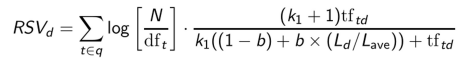

In [70]:
import math
bm25 = {}
k = 1.2
b = 0.75
Lave = 0
N = len(mapping_dict)

for doc in json_processed:
  Lave += len(doc['Tweet'])

Lave = Lave / N

for q in queries.keys():
  bm25[q] = dict()
  for d in mapping_dict.values():
    bm25[q][d] = 0.0  # initialize document dictionaries

for term in inverted_index: 
  df = len(inverted_index[term])  # document frequency of the term 
  for q, terms in queries.items():  # iterate over queries
    f = terms.count(term)  # term frequency of the term in the query q

    for doc in inverted_index[term]: # iterate over documents
      Ld = len(json_processed[list(mapping_dict.values()).index(doc[0][0])]['Tweet'])  # lenght of the document
      bm25[q][doc[0][0]] += math.log(N/df, 2) * ((k + 1) * f) / (k*((1-b) + b*(Ld / Lave)) + f)  # formula bm25
      

In [79]:

# Python3 code to demonstrate working of
# N largest values in dictionary
# Using nlargest
from heapq import nlargest
  
# Initialize dictionary
test_dict = {'gfg' : 1, 'is' : 4, 'best' : 6, 'for' : 7, 'geeks' : 3 }
  
# Initialize N 
N = 3
  
# N largest values in dictionary
# Using nlargest
res = nlargest(N, test_dict, key = test_dict.get)
  
# printing result
print("The top N value pairs are  " + str(res))

The original dictionary is : {'gfg': 1, 'is': 4, 'best': 6, 'for': 7, 'geeks': 3}
The top N value pairs are  ['for', 'best', 'is']


In [84]:
from operator import itemgetter
#Ranking BM25
print("Ranking BM25")
i=1
N=5
for q in queries:
  res = nlargest(N, bm25[q], key = bm25[q].get)
  print("Ranking for query"+str(i)+":" + str(res))
  i=i+1

Ranking BM25
Ranking for query1:['doc_3287', 'doc_1012', 'doc_3954', 'doc_3088', 'doc_3884']
Ranking for query2:['doc_1110', 'doc_3253', 'doc_3418', 'doc_2151', 'doc_3898']
Ranking for query3:['doc_1331', 'doc_670', 'doc_1192', 'doc_1732', 'doc_1466']
Ranking for query4:['doc_2283', 'doc_725', 'doc_3150', 'doc_2368', 'doc_3057']
Ranking for query5:['doc_253', 'doc_1151', 'doc_336', 'doc_3285', 'doc_2182']


##Word2vec + Cosine similarity

In [85]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

tweets_dict =[]
for i, j in enumerate(json_processed):
  tweets_dict.append({})
  tweets_dict[i]['ID'] = j['doc_id'][0]
  tweets_dict[i]['text'] = j['Tweet']

model = Word2Vec(window=5, min_count=1, workers=4)
model.build_vocab(tweets, progress_per=100)
model.train(tweets, total_examples=model.corpus_count, epochs=30, report_delay=1)

(1711044, 1922310)

In [86]:
def topW2V(query, inv_index, tweets, model_w2v):
    
  query_cleaned = clean_tweet(query, True)
  tweet_ids = []
  for pos, term in enumerate(query_cleaned):
    if term in inverted_index:
      for id in inverted_index[term]:
        tweet_ids.append(id[0][0])

  tweet_ids = set(tweet_ids)

  word_vectors = model.wv

  tweetVectors = {}
  for ids in tweet_ids:
      for t in tweets_dict:
          if t['ID'] == ids:
              twords = t['text']
      
      wordspresent = [word for word in twords if word in model.wv]
      vector = np.mean(model.wv[wordspresent], axis=0)
      tweetVectors[ids] = vector
  
  wordspresent = [word for word in query if word in model.wv]
  queryVector =  np.mean(model.wv[wordspresent], axis=0)
  
  tweetScores = [ [np.dot(curTweetVec, queryVector), tweet_id] for tweet_id, curTweetVec in tweetVectors.items() ]
  tweetScores.sort(reverse=True)
  resultTweets = [x[1] for x in tweetScores][:20]
  resultScores = [x[0] for x in tweetScores][:20]
  
  return  resultTweets, resultScores

In [87]:
query = 'Last hurricane in Florida'
print("Query 1: ", query)
docs, scores = topW2V(query, inverted_index, tweets_dict, model)
for i in range(20):
    print(i+1, ") Document id: ", docs[i], "\tScores: ", scores[i])

Query 1:  Last hurricane in Florida
1 ) Document id:  doc_396 	Scores:  11.328721
2 ) Document id:  doc_1879 	Scores:  11.1494665
3 ) Document id:  doc_329 	Scores:  11.135919
4 ) Document id:  doc_142 	Scores:  11.019828
5 ) Document id:  doc_636 	Scores:  10.968319
6 ) Document id:  doc_52 	Scores:  10.861054
7 ) Document id:  doc_1621 	Scores:  10.67009
8 ) Document id:  doc_397 	Scores:  10.461354
9 ) Document id:  doc_709 	Scores:  10.2864485
10 ) Document id:  doc_1522 	Scores:  10.251562
11 ) Document id:  doc_401 	Scores:  10.139193
12 ) Document id:  doc_648 	Scores:  10.1058035
13 ) Document id:  doc_919 	Scores:  9.974082
14 ) Document id:  doc_1274 	Scores:  9.960842
15 ) Document id:  doc_2340 	Scores:  9.946055
16 ) Document id:  doc_1559 	Scores:  9.892986
17 ) Document id:  doc_2670 	Scores:  9.866786
18 ) Document id:  doc_1216 	Scores:  9.791836
19 ) Document id:  doc_2918 	Scores:  9.779519
20 ) Document id:  doc_212 	Scores:  9.779373


In [88]:
query = 'Terrible hurricane north carolina'
print("Query 2: ", query)
docs, scores = topW2V(query, inverted_index, tweets_dict, model)
for i in range(20):
    print(i+1, ") Document id: ", docs[i], "\tScores: ", scores[i])

Query 2:  Terrible hurricane north carolina
1 ) Document id:  doc_493 	Scores:  11.242565
2 ) Document id:  doc_856 	Scores:  10.849669
3 ) Document id:  doc_682 	Scores:  10.7745075
4 ) Document id:  doc_2505 	Scores:  10.721992
5 ) Document id:  doc_249 	Scores:  10.721992
6 ) Document id:  doc_574 	Scores:  10.707179
7 ) Document id:  doc_2430 	Scores:  10.665708
8 ) Document id:  doc_230 	Scores:  10.299946
9 ) Document id:  doc_1677 	Scores:  10.274606
10 ) Document id:  doc_396 	Scores:  9.955614
11 ) Document id:  doc_3401 	Scores:  9.854773
12 ) Document id:  doc_329 	Scores:  9.789286
13 ) Document id:  doc_254 	Scores:  9.784497
14 ) Document id:  doc_1879 	Scores:  9.739617
15 ) Document id:  doc_142 	Scores:  9.67675
16 ) Document id:  doc_308 	Scores:  9.638253
17 ) Document id:  doc_636 	Scores:  9.637166
18 ) Document id:  doc_1435 	Scores:  9.629877
19 ) Document id:  doc_1749 	Scores:  9.623742
20 ) Document id:  doc_52 	Scores:  9.553759


In [89]:
query = 'Medical assistance Florida'
print("Query 3: ", query)
docs, scores = topW2V(query, inverted_index, tweets_dict, model)
for i in range(20):
    print(i+1, ") Document id: ", docs[i], "\tScores: ", scores[i])

Query 3:  Medical assistance Florida
1 ) Document id:  doc_1879 	Scores:  9.215849
2 ) Document id:  doc_979 	Scores:  7.770424
3 ) Document id:  doc_973 	Scores:  7.770424
4 ) Document id:  doc_934 	Scores:  7.770424
5 ) Document id:  doc_775 	Scores:  7.3960247
6 ) Document id:  doc_696 	Scores:  7.3960247
7 ) Document id:  doc_395 	Scores:  7.322478
8 ) Document id:  doc_385 	Scores:  7.322478
9 ) Document id:  doc_208 	Scores:  7.322478
10 ) Document id:  doc_462 	Scores:  7.318345
11 ) Document id:  doc_423 	Scores:  7.318345
12 ) Document id:  doc_422 	Scores:  7.318345
13 ) Document id:  doc_242 	Scores:  7.263157
14 ) Document id:  doc_3524 	Scores:  7.252019
15 ) Document id:  doc_74 	Scores:  7.235702
16 ) Document id:  doc_137 	Scores:  7.235702
17 ) Document id:  doc_109 	Scores:  7.235702
18 ) Document id:  doc_240 	Scores:  7.1903176
19 ) Document id:  doc_2877 	Scores:  7.1438727
20 ) Document id:  doc_813 	Scores:  7.1390157


In [90]:
query = 'Last news report Ian'
print("Query 4: ", query)
docs, scores = topW2V(query, inverted_index, tweets_dict, model)
for i in range(20):
    print(i+1, ") Document id: ", docs[i], "\tScores: ", scores[i])

Query 4:  Last news report Ian
1 ) Document id:  doc_493 	Scores:  15.307343
2 ) Document id:  doc_856 	Scores:  14.929156
3 ) Document id:  doc_141 	Scores:  14.544408
4 ) Document id:  doc_1677 	Scores:  13.7233925
5 ) Document id:  doc_3401 	Scores:  13.460128
6 ) Document id:  doc_396 	Scores:  13.418342
7 ) Document id:  doc_1879 	Scores:  13.095746
8 ) Document id:  doc_142 	Scores:  12.982881
9 ) Document id:  doc_52 	Scores:  12.813111
10 ) Document id:  doc_1621 	Scores:  12.735885
11 ) Document id:  doc_397 	Scores:  12.535187
12 ) Document id:  doc_1913 	Scores:  12.324146
13 ) Document id:  doc_1501 	Scores:  12.250925
14 ) Document id:  doc_401 	Scores:  12.062205
15 ) Document id:  doc_919 	Scores:  12.040468
16 ) Document id:  doc_648 	Scores:  12.0359
17 ) Document id:  doc_2918 	Scores:  11.949384
18 ) Document id:  doc_1559 	Scores:  11.917552
19 ) Document id:  doc_1163 	Scores:  11.904561
20 ) Document id:  doc_2340 	Scores:  11.894253


In [91]:
query = 'Dealing with east coast tragedy'
print("Query 5: ", query)
docs, scores = topW2V(query, inverted_index, tweets_dict, model)
for i in range(20):
    print(i+1, ") Document id: ", docs[i], "\tScores: ", scores[i])

Query 5:  Dealing with east coast tragedy
1 ) Document id:  doc_574 	Scores:  11.979263
2 ) Document id:  doc_2173 	Scores:  10.384233
3 ) Document id:  doc_1522 	Scores:  10.220981
4 ) Document id:  doc_1501 	Scores:  10.140835
5 ) Document id:  doc_1918 	Scores:  10.127721
6 ) Document id:  doc_1559 	Scores:  9.959787
7 ) Document id:  doc_1274 	Scores:  9.929632
8 ) Document id:  doc_1734 	Scores:  9.80133
9 ) Document id:  doc_3280 	Scores:  9.646456
10 ) Document id:  doc_171 	Scores:  9.640384
11 ) Document id:  doc_122 	Scores:  9.614965
12 ) Document id:  doc_3265 	Scores:  9.591692
13 ) Document id:  doc_2358 	Scores:  9.573197
14 ) Document id:  doc_686 	Scores:  9.558461
15 ) Document id:  doc_2464 	Scores:  9.505338
16 ) Document id:  doc_1189 	Scores:  9.475715
17 ) Document id:  doc_2785 	Scores:  9.289776
18 ) Document id:  doc_3898 	Scores:  9.271352
19 ) Document id:  doc_1281 	Scores:  9.179617
20 ) Document id:  doc_3758 	Scores:  9.152229
